<a href="https://colab.research.google.com/github/ngang002/CountyData/blob/main/cleanCountyData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install datacommons_pandas
!pip install datacommons_pandas --upgrade --quiet
# Import Data Commons
import datacommons_pandas as dc

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
%matplotlib notebook
%matplotlib inline

# prompt: Implementing a clustering algorithm to group like states together
# the question now is what are they being grouped by?


import json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.8 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn as sk
import sklearn.cluster
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
import numpy as np

In [4]:
# Read CSV files from the census data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir("/content/drive/My Drive/Colab Notebooks")

TABLE = pd.read_csv('ACSDP1Y2022.DP03-2024-08-26T034006.csv')
print(f"Number of columns {len(TABLE.columns)}")
print(f"Number of rows {len(TABLE.index)//3}")


Mounted at /content/drive
Number of columns 146
Number of rows 848


# Data Selection

We know that we have 146 data columns, and 848 rows, which means we have data on 848 unique counties (each county takes up three rows upon inspection of the dataset).  The rows constitues "Name"/"Headers", Raw Population, and Percentage Data.  In our case we want to select the percentage data, because our analysis largely depends on the fraction of a given population.  Using the raw population data could skew our results, giving more weight to counties with more people.  However, we should keep in mind that our analysis could be missing an intrinsic correlation between the populations and the parameters we study.  

In [5]:
def getPercentageRows(df):
  countyNames = df.loc[::3, 'Label (Grouping)'].values
  origTable = df.iloc[1::3].copy()
  percTable = df.iloc[2::3].copy()
  origTable.insert(1, 'County', countyNames)
  origTable.set_index('County', inplace=True)
  percTable.insert(1, 'County', countyNames)
  percTable.set_index('County', inplace=True)

  outTable = pd.DataFrame()
  series_list = []
  for __, _ in enumerate(origTable.columns):
    if __ == 0: continue

    if np.all(percTable.loc[:,_].isna()): continue
    if np.all(percTable.loc[:,_] == '(X)'):
      dat = origTable[_].values
    else:
      dat = percTable[_].values

    if ('%' in dat[0]):
      dat = np.vectorize(lambda x: x.replace('%',''))(dat)
      dat[dat == 'N'] = 0.
      dat[dat == '-'] = 0.
      dat = dat.astype(float)/100. # Converting floats to percentages
    elif (',' in dat[0]):
      dat = np.vectorize(lambda x: x.replace(',',''))(dat)
      dat[dat == 'N'] = 0.
      dat[dat == '-'] = 0.
      dat = dat.astype(float)

    series_list.append(pd.Series(dat, name=_, index=percTable.index))

  outTable = pd.concat(series_list, axis=1)
  outTable.insert(1, 'County', countyNames)
  outTable.set_index('County', inplace=True)
  return outTable

outTable = getPercentageRows(TABLE)
print(outTable.columns)

Index(['EMPLOYMENT STATUS!!Population 16 years and over',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Employed',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Civilian labor force!!Unemployed',
       'EMPLOYMENT STATUS!!Population 16 years and over!!In labor force!!Armed Forces',
       'EMPLOYMENT STATUS!!Population 16 years and over!!Not in labor force',
       'EMPLOYMENT STATUS!!Civilian labor force',
       'EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate',
       'EMPLOYMENT STATUS!!Females 16 years and over',
       ...
       'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people',
       'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE

# Column Information

In the above table, we have selected all the data with percent information (the number of people in a given "column" selected normalized by the total population of the county).  However, we must now parse out the names of the columns, as not all columns have data.  This is becuase the structure of the column data is given by:

Column!!Sub-Column 1!!Sub-Sub Column 1!!Sub-Sub_Sub Column 1

Column!!Sub-Column 1!!Sub-Sub Column 1!!Sub-Sub_Sub Column 2

Column!!Sub-Column 1!!Sub-Sub Column 1!!Sub-Sub_Sub Column 3

Column!!Sub-Column 1!!Sub-Sub Column 2!!Sub-Sub_Sub Column 1

Column!!Sub-Column 1!!Sub-Sub Column 2!!Sub-Sub_Sub Column 2

Column!!Sub-Column 2!!Sub-Sub Column 1

We parse this by splitting based on the "!!" delimeter.


In [6]:
def cleanColumnNames(df):
  colNames = df.columns.tolist()

  colNames = [x.split('!!') for x in colNames]
  print(f"Number of columns {len(colNames)}")
  HEAD_COLS = []

  df_Occupation = pd.DataFrame()
  df_Industry = pd.DataFrame()
  df_Salaries = pd.DataFrame()
  df_HealthInsurance = pd.DataFrame()
  df_CommutingToWork = pd.DataFrame()
  for xx, x in enumerate(colNames):

    if len(x) == 1: HEAD_COLS.append(x[0])

    matching = [s for s in x if "INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)" in x]
    if len(matching) > 0: print(matching)
    if "INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)" in x:
      print("bleh", x, '!!'.join(str(_) for _ in x))
      # print(df[['!!'.join(str(_) for _ in x)]].values)
      if x[-1] == 'Mean household income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      if x[-1] == 'Median household income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      if x[-1] == 'Mean retirement income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      if x[-1] == 'Median retirement income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      if x[-1] == 'Mean Supplemental Security Income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      if x[-1] == 'Median Supplemental Security Income (dollars)':
        df_Salaries[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)


    matching = [s for s in x if "CLASS OF WORKER" in x and 'Civilian noninstitutionalized population 19 to 64 years' in x]
    if len(matching) > 0: print(matching)
    if "CLASS OF WORKER" in x and len(x) == 3:
      df_Occupation[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      # print(df_Occupation[x[-1]])

    matching = [s for s in x if "OCCUPATION" in x and 'Civilian noninstitutionalized population 19 to 64 years' in x]
    if len(matching) > 0: print(matching)
    if "OCCUPATION" in x and len(x) == 3:
      df_Occupation[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)


    # Selection based on Industry
    # matching = [s for s in x if "INDUSTRY" in x]
    # Selecting of industry
    matching = [s for s in x if "INDUSTRY" in x and 'Civilian noninstitutionalized population 19 to 64 years' in x]
    if len(matching) > 0: print(matching)
    if "INDUSTRY" in x and len(x) > 2:
      df_Industry[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)


    # Selection based on commuting to work
    matching = [s for s in x if "COMMUTING TO WORK" in x and 'Civilian noninstitutionalized population 19 to 64 years' in x]
    if "COMMUTING TO WORK" in x and len(x) > 2:
      try:
        df_CommutingToWork[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      except:
        x = colNames[xx-1]
        df_CommutingToWork[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)


    # Selection based on health insurance to work
    matching = [s for s in x if "HEALTH INSURANCE COVERAGE" in x and 'Civilian noninstitutionalized population 19 to 64 years' in x]
    if len(matching) > 0: print(matching)
    if "HEALTH INSURANCE COVERAGE" in x and len(x) == 4:
      df_HealthInsurance[x[-1]] = df['!!'.join(str(_) for _ in x)].values.astype(float)
      # print(df_HealthInsurance[x[-1]])

  print(HEAD_COLS)
  return df_HealthInsurance, df_CommutingToWork, df_Industry, df_Salaries

df_HealthInsurance, df_CommutingToWork, df_Industry, df_Salaries = cleanColumnNames(outTable)


Number of columns 137
['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households']
bleh ['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households'] INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households
['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households', 'Less than $10,000']
bleh ['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households', 'Less than $10,000'] INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!Less than $10,000
['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households', '$10,000 to $14,999']
bleh ['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households', '$10,000 to $14,999'] INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)!!Total households!!$10,000 to $14,999
['INCOME AND BENEFITS (IN 2022 INFLATION-ADJUSTED DOLLARS)', 'Total households', '$15,000 to $24,999']
bleh ['INCOME AND BENEFI

Our current method implies that there are 137 total data columns, however, only a subset of these columns are actually columns with data.  Many of these columns are "super"-columns or columns that consist of sub-columns.  In the cell above, I parsed through these "super"-columns and selected only those columns with data pertaining to the corresponding super-column.  This results in data across multiple different fields:

```
df_HealthInsurance, df_CommutingToWork, df_Industry, df_Salaries.
```

The names above refer to the super-columns, and the resulting datasets contain the percentage of the population which is encompassed in each sub-column.  For example in the HealthInsurance dataframe there are Privately_Insured, Publically_Insured, and Uninsured columns.  Other datasets are more complicated, however, each dataframe is sussed out to contain all the columns of a given super-column with data.  

In [7]:
# Print out the subcolumns within each major column
df_HealthInsurance, df_CommutingToWork, df_Industry, df_Salaries
print(df_Salaries.columns)
print(df_HealthInsurance.columns)
print(df_CommutingToWork.columns)
print(df_Industry.columns)

Index(['Median household income (dollars)', 'Mean household income (dollars)',
       'Mean retirement income (dollars)',
       'Mean Supplemental Security Income (dollars)'],
      dtype='object')
Index(['With private health insurance', 'With public coverage', 'Employed:',
       'Unemployed:', 'With health insurance coverage',
       'No health insurance coverage'],
      dtype='object')
Index(['Car, truck, or van -- drove alone', 'Car, truck, or van -- carpooled',
       'Public transportation (excluding taxicab)', 'Walked', 'Other means',
       'Worked from home', 'Mean travel time to work (minutes)'],
      dtype='object')
Index(['Agriculture, forestry, fishing and hunting, and mining',
       'Construction', 'Manufacturing', 'Wholesale trade', 'Retail trade',
       'Transportation and warehousing, and utilities', 'Information',
       'Finance and insurance, and real estate and rental and leasing',
       'Professional, scientific, and management, and administrative and waste 

# Data Exploration

In this next section, I go through each dataframe and plot a pairplot, at an attempt to observe if there are any over correlations between any other parameters.  Given the size of the dataset, coupled to the high-dimensionality of the data, reducing the number of dimensions can limit the amount of time examining the parameter space.  I am largely looking for fields which are indepdendent of each other, as strong correlations can be used with regression predictions for datasets not being used.  


In this Notebook I will compare HealthInsurance, CommutingToWork, Industry, and Salaries.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   With private health insurance   848 non-null    float64
 1   With public coverage            848 non-null    float64
 2   Employed:                       848 non-null    float64
 3   Unemployed:                     848 non-null    float64
 4   With health insurance coverage  848 non-null    float64
 5   No health insurance coverage    848 non-null    float64
dtypes: float64(6)
memory usage: 39.9 KB


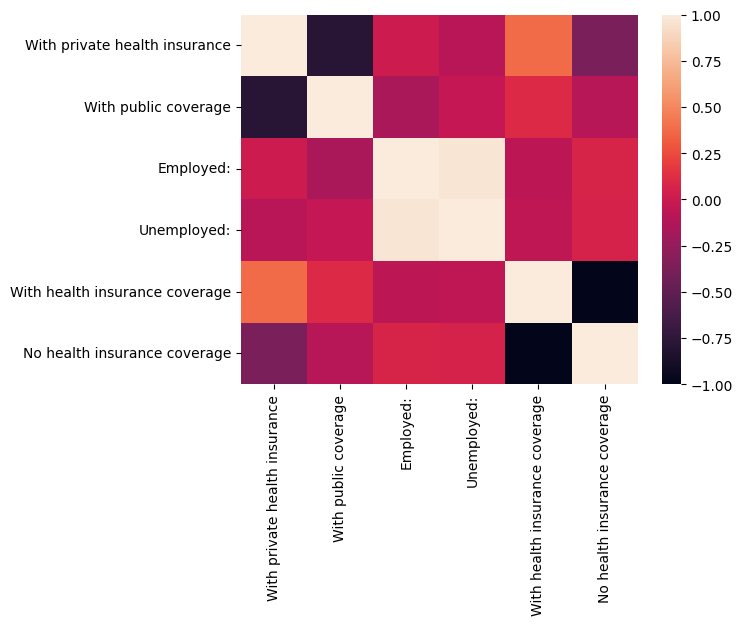

In [8]:
import seaborn as sns
df_HealthInsurance.info(verbose=True)
# sns.set_theme(style="darkgrid")
# g = sns.pairplot(df_HealthInsurance)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
g = sns.heatmap(df_HealthInsurance.corr())
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 7 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Car, truck, or van -- drove alone          848 non-null    float64
 1   Car, truck, or van -- carpooled            848 non-null    float64
 2   Public transportation (excluding taxicab)  848 non-null    float64
 3   Walked                                     848 non-null    float64
 4   Other means                                848 non-null    float64
 5   Worked from home                           848 non-null    float64
 6   Mean travel time to work (minutes)         848 non-null    float64
dtypes: float64(7)
memory usage: 46.5 KB


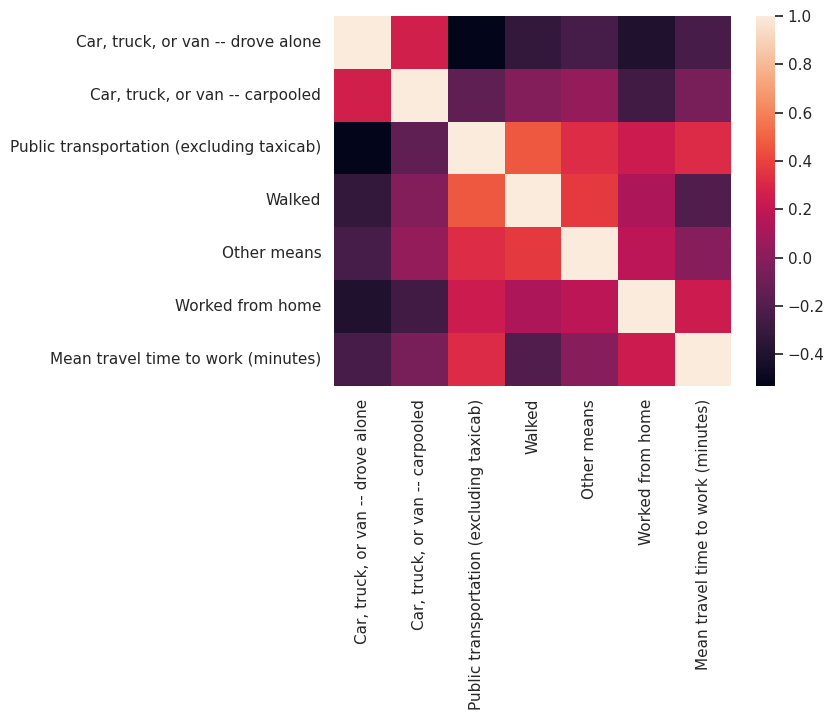

In [9]:
import seaborn as sns
df_CommutingToWork.info(verbose=True)
sns.set_theme(style="darkgrid")
# g = sns.pairplot(df_CommutingToWork)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
g = sns.heatmap(df_CommutingToWork.corr())
plt.show()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 13 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Agriculture, forestry, fishing and hunting, and mining                                      848 non-null    float64
 1   Construction                                                                                848 non-null    float64
 2   Manufacturing                                                                               848 non-null    float64
 3   Wholesale trade                                                                             848 non-null    float64
 4   Retail trade                                                                                848 non-null    float64
 5   Transportation and warehousing, and utiliti

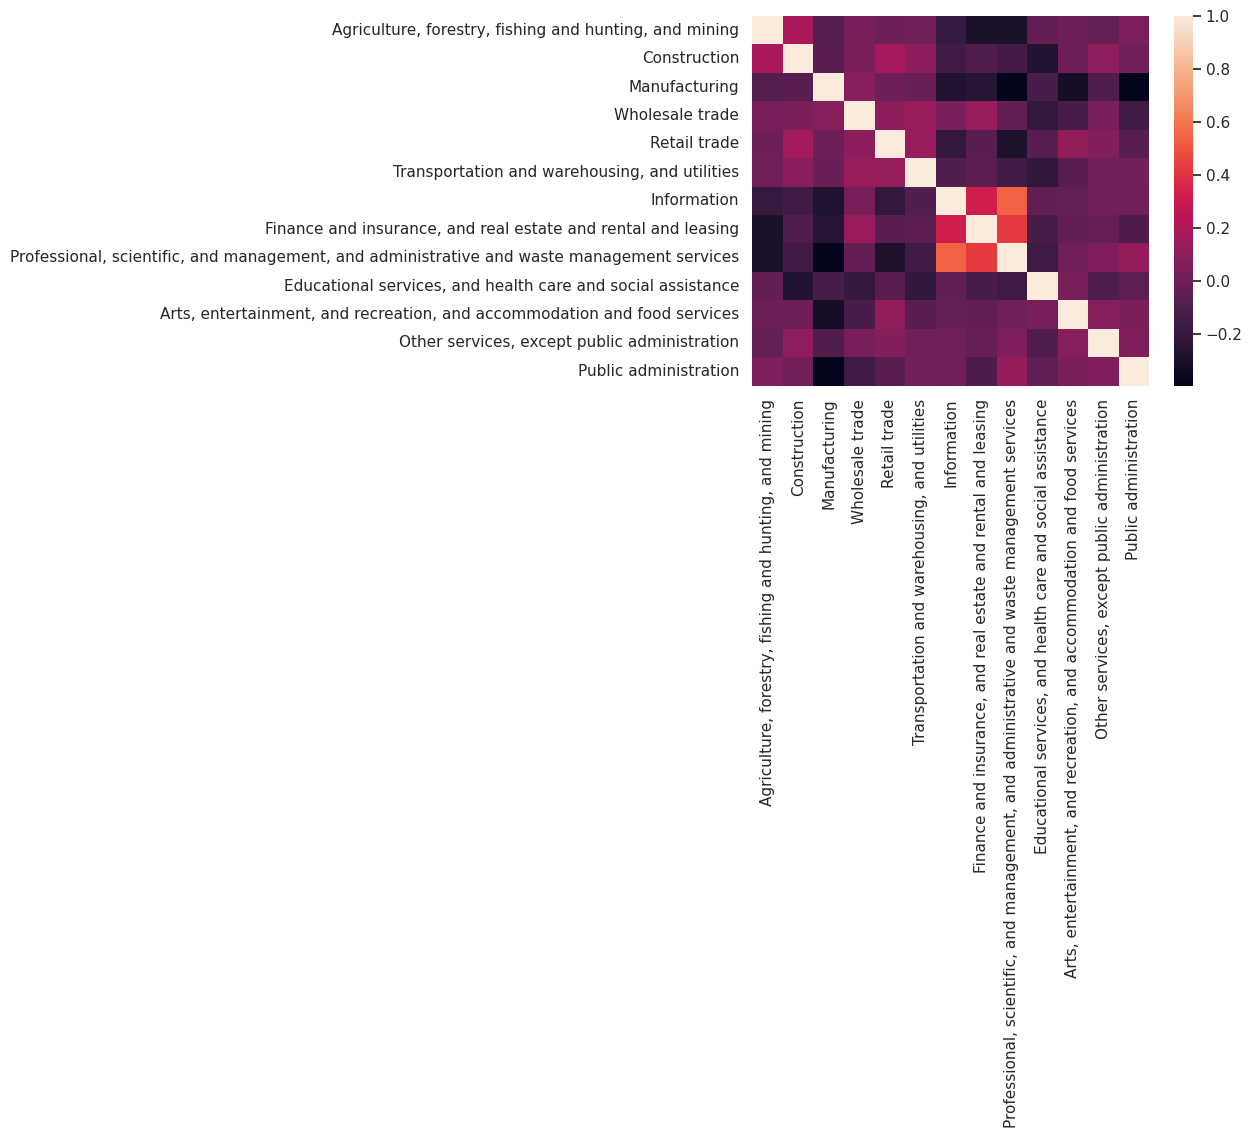

In [10]:
df_Industry.info(verbose=True)
sns.set_theme(style="darkgrid")
# g = sns.pairplot(df_Industry)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
g = sns.heatmap(df_Industry.corr())
plt.show()

# Industry

This large dataframe is difficult to parse through, and so I will go into some details about the fields myself.  Careers largely considered "low skilled labor" (including manufacturing, retail, wholesale trade, and, transportation) have weak if any correlations with each other, and are weakly anti-correlated (if at all) with "high skilled labor" fields (information, science, professional, realty, and financial).  This finding is quite surprising, since we would expect that a person working in one industry, is one less person working in another industry. However, in appears that in a high-dimensional phase space, with many different career types, this notion becomes substantially more convoluted.  It also seems indicative that in order for these larger counties to function at an adequately, it requires the need for all sectors of employment.  However, I do want to note that the correlation is slightly positive in between the "low skilled" and "high skilled", and anti-correlations between a "low skill" and "high skill" pair. As such, I take the 2 of each "high skilled" and "low skilled" labor jobs and relate them to the median income later in the notebook.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 4 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Median household income (dollars)            848 non-null    float64
 1   Mean household income (dollars)              848 non-null    float64
 2   Mean retirement income (dollars)             848 non-null    float64
 3   Mean Supplemental Security Income (dollars)  848 non-null    float64
dtypes: float64(4)
memory usage: 26.6 KB


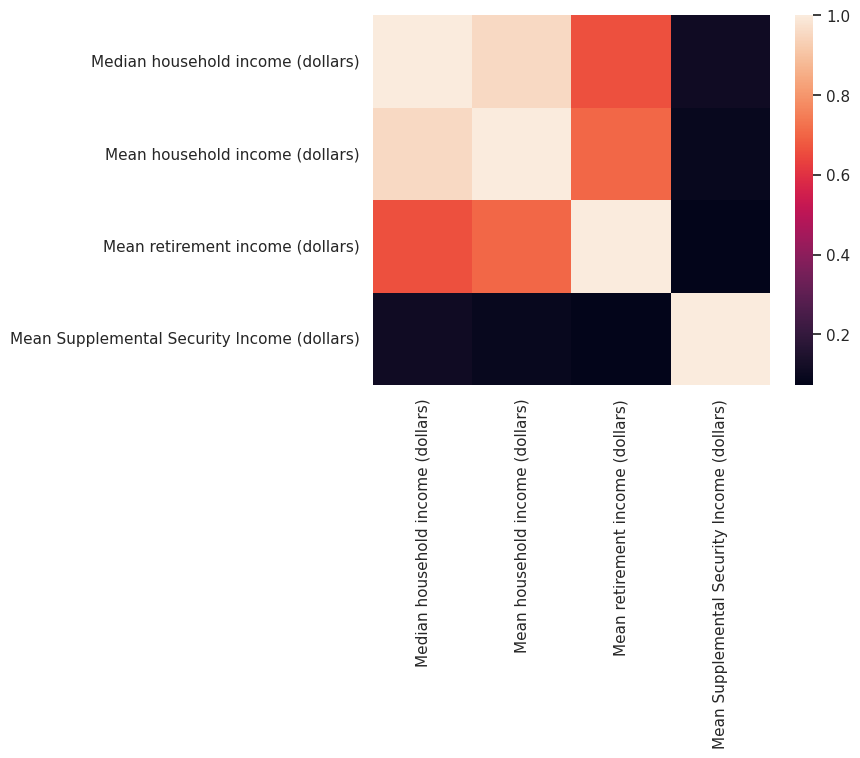

In [11]:
# print(df_Salaries)
df_Salaries.info(verbose=True)
sns.set_theme(style="darkgrid")
# print(df_Salaries)
# g = sns.pairplot(df_Salaries)
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot)
# g.add_legend()
g = sns.heatmap(df_Salaries.corr())
plt.show()

After doing extensive data exploration, by comparing the independent variables within a given super-column, I attempt select which variables are best primed to predict the median household income.  From my analysis we can observe that some indicators are strongly correlated with others, allowing us to reduce the dimensionality of our dataset.  We can explore now how our median household income relates to those columns which are linearly independent of the other columns in our dataset (i.e. where one column cannot be entirely explained with a correlation in another).  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848 entries, 0 to 847
Data columns (total 7 columns):
 #   Column                                                                                      Non-Null Count  Dtype  
---  ------                                                                                      --------------  -----  
 0   Median household income (dollars)                                                           848 non-null    float64
 1   With private health insurance                                                               848 non-null    float64
 2   Car, truck, or van -- drove alone                                                           848 non-null    float64
 3   Retail trade                                                                                848 non-null    float64
 4   Manufacturing                                                                               848 non-null    float64
 5   Professional, scientific, and management, an

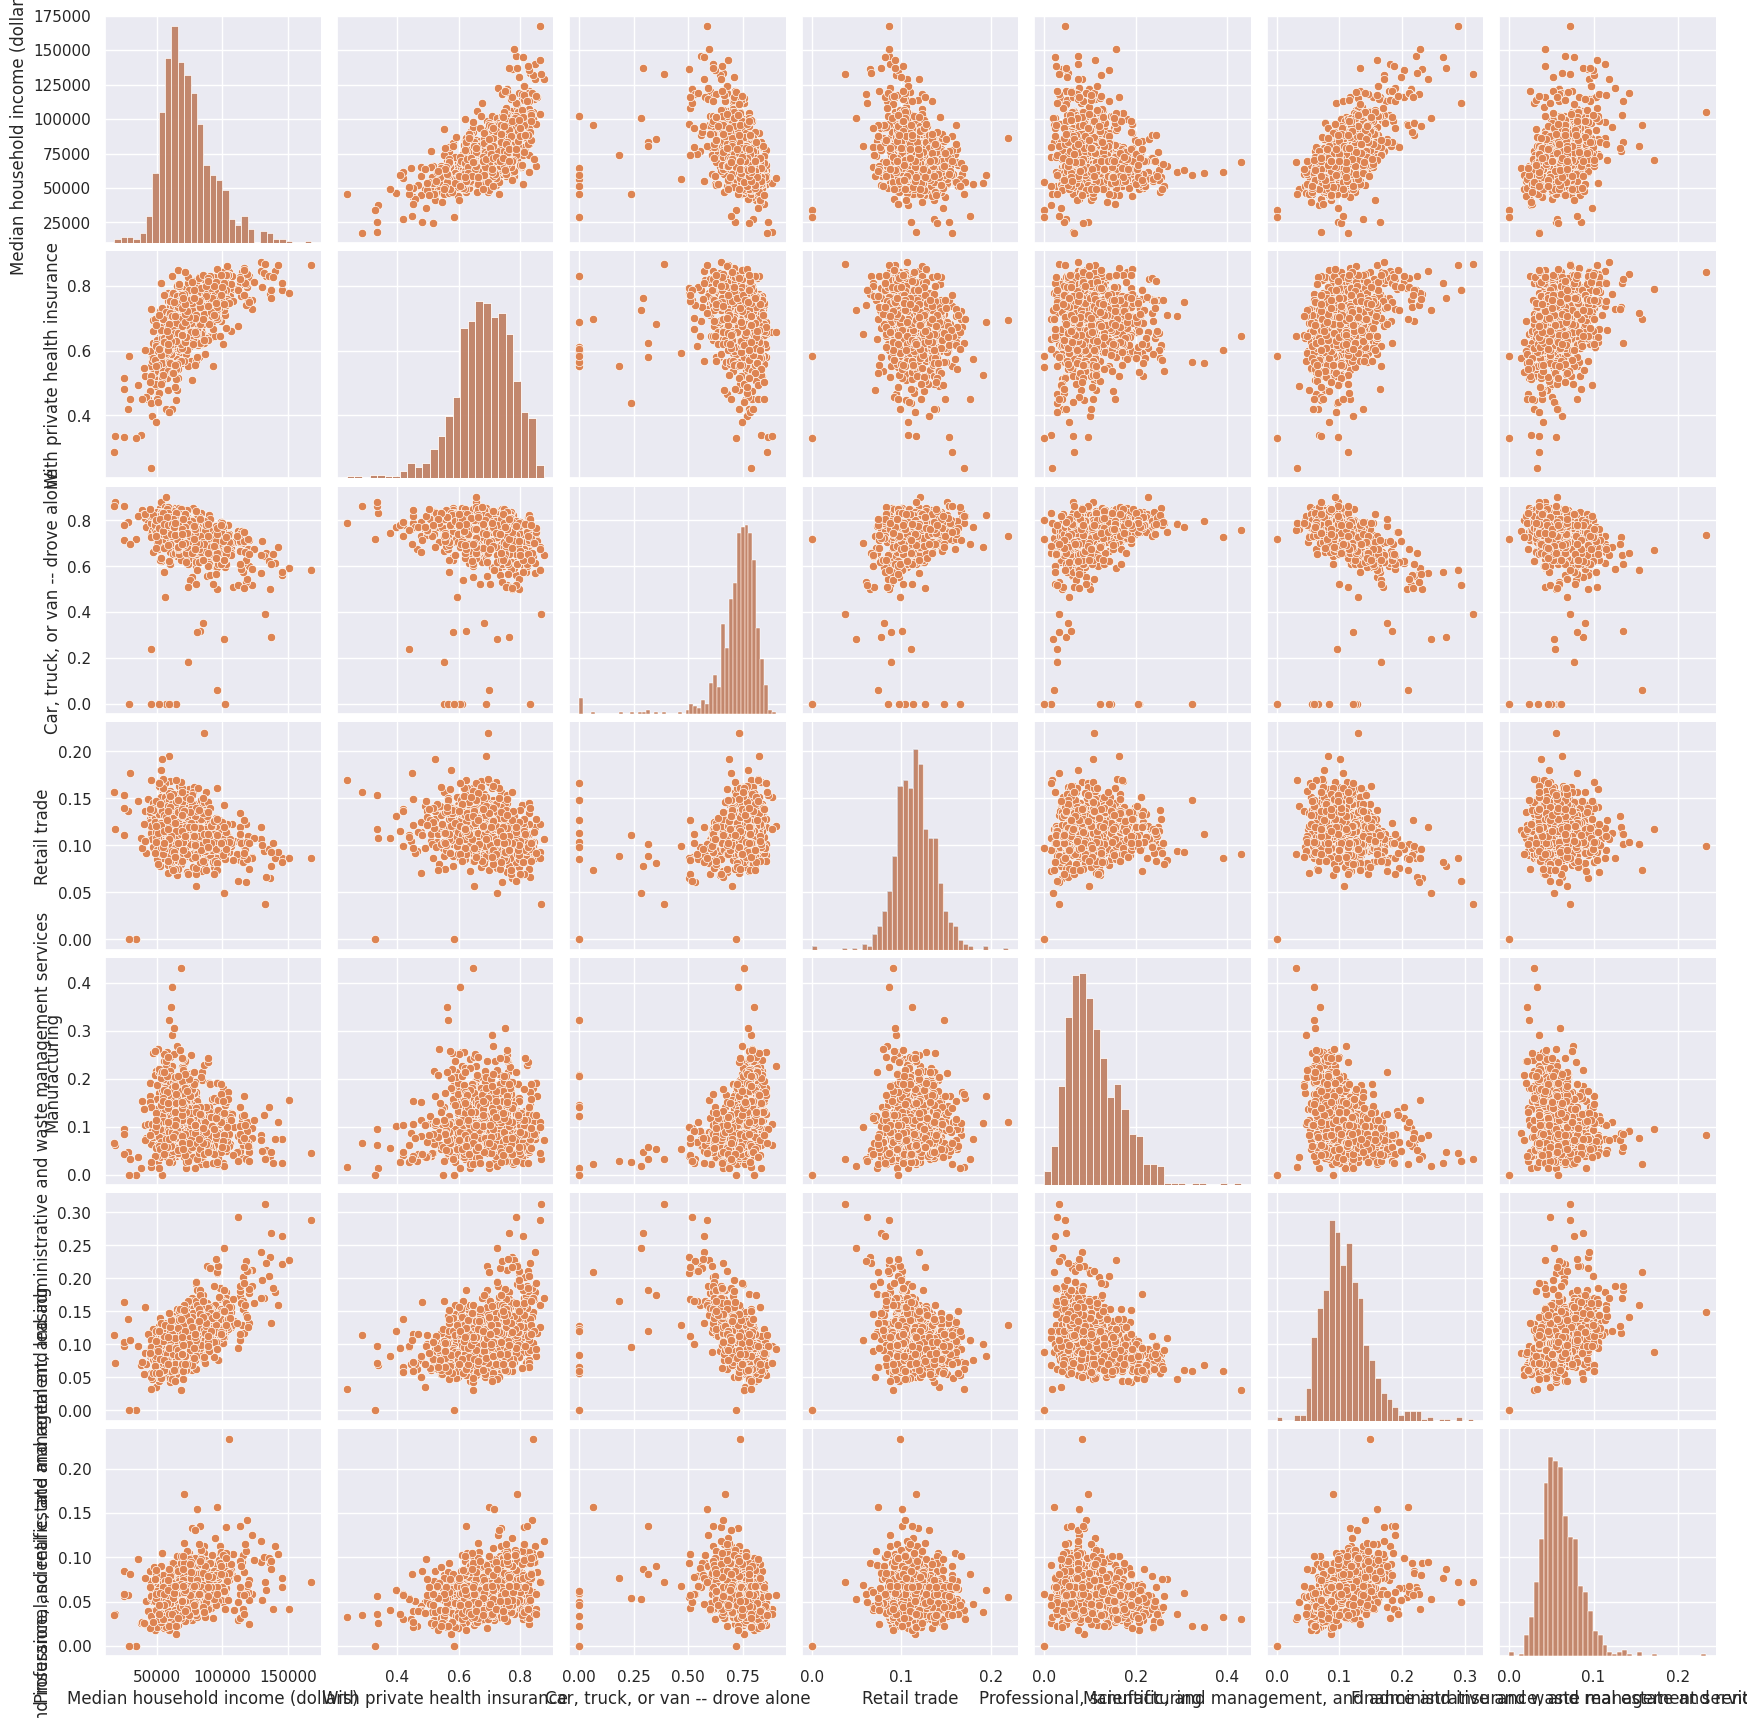

In [12]:
df_FULL = pd.concat([df_Salaries[['Median household income (dollars)',]], \
                     df_HealthInsurance[['With private health insurance',]], \
                     df_CommutingToWork[['Car, truck, or van -- drove alone']], \
                     df_Industry[['Retail trade', 'Manufacturing', 'Professional, scientific, and management, and administrative and waste management services', 'Finance and insurance, and real estate and rental and leasing']]], axis=1)


df_FULL.info(verbose=True)
sns.set_theme(style="darkgrid")
g = sns.pairplot(df_FULL)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()
plt.show()

From doing some basic, yet extensive, data exploration, I found that a large indicator of whether a county pays more money (as a median) was strongly correlated with the percentage of jobs that were considered "Work from home" (and by extension did not commute or had lower levels of commuting generally), had a private health insurance provider, and were in the finance, insurance, real estate, or any other industry that required selling services (NOT GOODS unless higher end good like homes), and professional, scientific, and management, and administrative and waste management services jobs.  This in all likelihood is because these careers are more indicative of locations where white collar and high skilled jobs are more available over more unskilled jobs.

After doing some data engineering, and attempting to find correlations between the median income and some career properties, I selected the properties that indicate some kind of medium to strong correlations.  The reason on selecting these variables is because these parameters are potential indicators of counties in which the median income are higher.  

# Creating Predictive Models

In this next cell I will be running a few different ML methods.  In the cell below we utilize Linear Regression to predict the median income based on some of the localized county variables.  The first step of the process however is to scale the data, and to this end I use the standard scaler since many of the independent variables we are observing are Gaussian in nature.  I compare the results of the Standard Scaler to that of the Polynomial Scaler.  

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

y = df_FULL['Median household income (dollars)']
X = df_FULL.loc[:, df_FULL.columns != 'Median household income (dollars)']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=108, test_size=0.1)


print(f"Number of train data: {len(X_train)} and test data:{len(X_test)} ")

scaler = StandardScaler()
# Testing out the linear regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
linreg = LinearRegression()
linreg.fit(X_train_scaled, y_train)
y_pred_lin = linreg.predict(X_test_scaled)
print(f"Standard Scaled Training Score: {linreg.score(X_train_scaled, y_train)}")
print(f"Standard Scaled Testing Score: {linreg.score(X_test_scaled, y_test)}")

# Let's see if polynomial features can handle that curve. Using interactions only to limit the number of features and preserve some interpretability.
poly = PolynomialFeatures(interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)
polyreg = LinearRegression()
polyreg.fit(X_train_poly_scaled, y_train)
y_pred_poly = polyreg.predict(X_test_poly_scaled)
print(f"Polynomial Scaled Training Score: {polyreg.score(X_train_poly_scaled, y_train)}")
print(f"Polynomial Scaled Testing Score: {polyreg.score(X_test_poly_scaled, y_test)}")

# Making a quick dictionary of coefficients
coef_dict = dict()
for i in range(len(X.columns)):
    coef_dict[X.columns[i]] = linreg.coef_[i]
# Sorting it by absolute value of coef to get a list of the top coefs
sorted_coef_dict = sorted([(abs(value), key) for (key,value) in coef_dict.items()], reverse=True)
print(f"{sorted_coef_dict}")

Number of train data: 763 and test data:85 
Standard Scaled Training Score: 0.6736805014242341
Standard Scaled Testing Score: 0.6033042323756586
Polynomial Scaled Training Score: 0.7238472536551366
Polynomial Scaled Testing Score: 0.6473599956136988
[(10358.619434245242, 'With private health insurance'), (7854.937363889065, 'Professional, scientific, and management, and administrative and waste management services'), (1438.2613448714778, 'Retail trade'), (953.6426721482903, 'Car, truck, or van -- drove alone'), (730.3632139248916, 'Manufacturing'), (295.34582127167323, 'Finance and insurance, and real estate and rental and leasing')]


Text(0, 0.5, 'Predicted ($)')

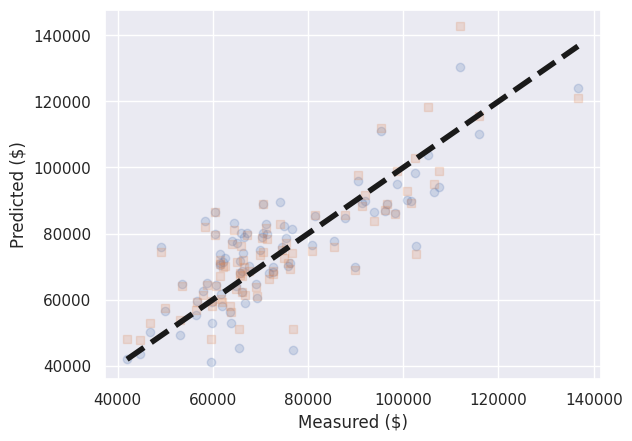

In [14]:
fig, ax = plt.subplots()
ax.plot(y_test, y_pred_lin, 'o', alpha=0.2)
ax.plot(y_test, y_pred_poly, 's', alpha=0.2)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Measured ($)')
ax.set_ylabel('Predicted ($)')

# Result

We see above the the Linear Regression model does a relatively good job at predicting the median income of a county, given our set of independent variables.  We find that the strongest indicator whether a county as a large median household income (or the indicator with the largest slope) is the presence of companies which provide health insurance to their employees.  This is then followed by counties where the primary Industry is in Science, Management or Adminisitrative work, who were also allowed to work from home.  This suggests that counties which require more high-skilled labor, and likely in science and technology have the largest median income.  

Meanwhile, the median income is not as strongly correlated with finance, retail, and manufacturing, and which require their employees to then drive to work (via car, van, or truck).  However, we must be careful, and this in all likelihood would require a more exopansive observation of the parameter space, as other independent variables that we have could indicate otherwise.  Despite the strong correlation from our predictions, we must be hesitant to take these results at face value.

# Other Machine Learning Models

In this next section we compare the Linear Regression model with other, more complex models like the Decision Tree, Random Forest, and GradientBoostingRegressor.  However, we find that there is not substantial improvement using these models as compared to the Linear Regression model.  In fact the XGBoost and Random Forests perform the worst.

In [15]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

y = df_FULL['Median household income (dollars)']
X = df_FULL.loc[:, df_FULL.columns != 'Median household income (dollars)']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=108, test_size=0.1)


print(f"Number of train data: {len(X_train)} and test data:{len(X_test)} ")

scaler = StandardScaler()
# Testing out the linear regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("Working with the Decision Tree")
for i in range(1, len(df_FULL.columns)+5):
  decTreeReg = DecisionTreeRegressor(max_depth=i)
  decTreeReg.fit(X_train_scaled, y_train)
  y_pred_decTree = decTreeReg.predict(X_test_scaled)
  print(decTreeReg.score(X_train_scaled, y_train))
  print(decTreeReg.score(X_test_scaled, y_test))
  print("\n \n \n")


Number of train data: 763 and test data:85 
Working with the Decision Tree
0.3376860014557367
0.24927608231010034

 
 

0.5388134079181712
0.38436319056338875

 
 

0.6610141682315863
0.38463814671077934

 
 

0.7364932160871371
0.4748355994347886

 
 

0.7906220770681173
0.5155493976990393

 
 

0.8416603359289381
0.4830523777026674

 
 

0.8747288416243955
0.4298413102785771

 
 

0.9077200823322873
0.4240280978353157

 
 

0.9306874679615244
0.39218065320167894

 
 

0.9513117602313451
0.35335076450953884

 
 

0.9667438147933552
0.29686084374630684

 
 



In [16]:
print("Working with the Random Forest")
for i in range(1, len(df_FULL.columns)+5):
  randForestReg = RandomForestRegressor(max_depth=i, n_estimators=200)
  randForestReg.fit(X_train_scaled, y_train)
  y_pred_randForestReg = randForestReg.predict(X_test_scaled)
  print(randForestReg.score(X_train_scaled, y_train))
  print(randForestReg.score(X_test_scaled, y_test))
  print("\n \n \n")


Working with the Random Forest
0.40884913601549067
0.427900135527402

 
 

0.6163006213382116
0.5623087530609714

 
 

0.7226154025968655
0.5973376290376999

 
 

0.770625096856431
0.6377716137886938

 
 

0.8173114240635078
0.6452869026798818

 
 

0.854651213876754
0.6425817005407118

 
 

0.8865105840408736
0.6375872401828548

 
 

0.9117581529544848
0.6310703921308233

 
 

0.928457426527522
0.6393453937272441

 
 

0.9407469930314383
0.624793896973272

 
 

0.9499872412531501
0.6353395243953766

 
 



0.2303855159701985
0.028935154877614104


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Predicted ($)')

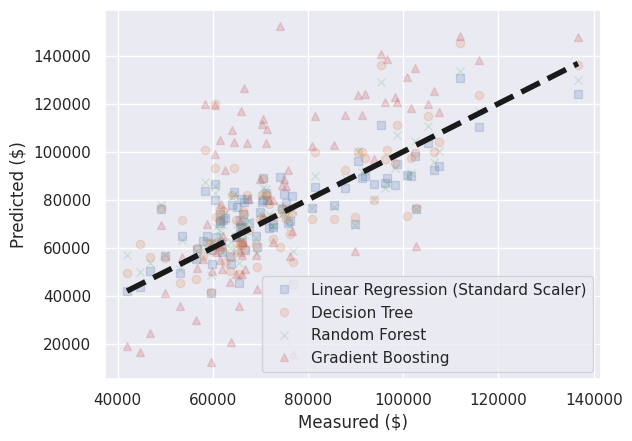

In [17]:
from sklearn.ensemble import GradientBoostingRegressor


xgBoostReg = GradientBoostingRegressor(random_state=0, n_estimators=500)
xgBoostReg.fit(X_train, y_train)

scaler = MinMaxScaler()
# Testing out the linear regression
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_pred_xgBoostReg = xgBoostReg.predict(X_test_scaled)
print(10**xgBoostReg.score(X_train_scaled, y_train))
print(10**xgBoostReg.score(X_test_scaled, y_test))

fig, ax = plt.subplots()
ax.plot(y_test, y_pred_lin, 's', alpha=0.2, label='Linear Regression (Standard Scaler)')
ax.plot(y_test, y_pred_decTree, 'o', alpha=0.2, label='Decision Tree')
ax.plot(y_test, y_pred_randForestReg, 'x', alpha=0.2, label='Random Forest')
ax.plot(y_test, y_pred_xgBoostReg, '^', alpha=0.2, label='Gradient Boosting')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.legend(loc='best')
ax.set_xlabel('Measured ($)')
ax.set_ylabel('Predicted ($)')


It seems that currently the most effective way, with the data selection techniques and feature engineering I implmemented, to determine the median income of a given county is to use Linear Regression.  This in large part is quite intuitive as many of these parameters that we selected on, are largely indicative of high skilled, stay-at-home based jobs in which a large fraction of the population is covered by private health insurance, payed off by employers.  These areas and jobs are highly sought after.  All of our models, save the Gradient Boosting method seemingly do an adequate job of calculating the median income of a household in a given county.  

However, further improvements to the model can be made, by expanding the number of independent variables we train over, increasing the sample size of the counties, and fine-tuning our models to return better results